In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


# PREPROCESSING DATA

In [8]:
df = pd.read_csv('/content/drive/MyDrive/PTDLKD/Data/Silver_Data.csv')
df = df[['Price']]
# print(df)
# Format column Price to float
# df['Price'] = df.Price.str.replace(',','').astype(float)

# Flip the column
df = df.iloc[::-1]

# Drop missing values
df = df.dropna()

# Reset the index
df = df.reset_index(drop=True)

# SPLITTING DATA(7-2-1)

In [9]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [10]:
!pip install pmdarima --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.2 MB/s eta 0:00:00


In [11]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', stepwise=True, suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1093.030, Time=1.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1110.324, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1095.073, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1096.888, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1108.610, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1095.640, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1096.230, Time=0.63 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.67 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1095.019, Time=1.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1091.748, Time=1.73 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1094.145, Time=0.67 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1090.419, Time=3.67 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1088.465, Time=0.70 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1

ARIMA(order=(0, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [12]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [13]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[23.48258291 23.4999298  23.42923412 23.394983   23.394983   23.394983
 23.394983   23.394983   23.394983   23.394983   23.394983   23.394983
 23.394983   23.394983   23.394983   23.394983   23.394983   23.394983
 23.394983   23.394983   23.394983   23.394983   23.394983   23.394983
 23.394983   23.394983   23.394983   23.394983   23.394983   23.394983  ]


In [14]:
# Calculate the accuracy for each model

from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  2.661993568998013
Testing MAE:  2.1806679357294274
Testing MAPE:  10.626247372570656
Validation RMSE:  1.4208573423873354
Validation MAE:  1.1244982989576238
Validation MAPE:  4.872986950677014


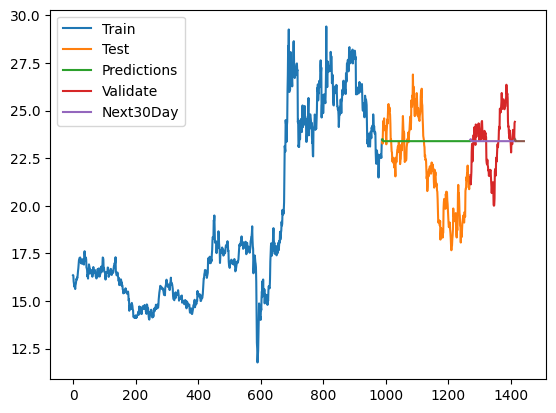

In [15]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Price'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  989
Model:               SARIMAX(0, 1, 4)   Log Likelihood                -538.450
Date:                Mon, 19 Jun 2023   AIC                           1086.900
Time:                        12:41:51   BIC                           1111.378
Sample:                             0   HQIC                          1096.208
                                - 989                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1261      0.017     -7.607      0.000      -0.159      -0.094
ma.L2          0.0698      0.019      3.692      0.000       0.033       0.107
ma.L3         -0.0372      0.018     -2.026      0.043      -0.073      -0.001
ma.L4         -0.0844      0.021     -4.040      0.000      -0.125      -0.043
sigma2         0.1741      0.003     54.235      0.000       0.168       0.180
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5482.43
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              14.10   Skew:                            -0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SPLITTING DATA(6-3-1)

In [17]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [18]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=940.148, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=961.077, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=945.654, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=948.263, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=959.569, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=942.500, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=943.783, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=938.974, Time=1.54 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=941.149, Time=0.63 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=937.932, Time=1.41 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=935.937, Time=1.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=935.316, Time=0.53 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=943.712, Time=0.29 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=936.311, Time=0.53 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=937.9

ARIMA(order=(4, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [19]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [20]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[25.14513359 25.17484453 25.18399596 25.20326457 25.1901058  25.19009893
 25.18742439 25.18598416 25.18736995 25.18712429 25.18761107 25.187649
 25.18754264 25.18757494 25.18750676 25.18751705 25.18752035 25.18751899
 25.18752669 25.18752435 25.18752503 25.18752469 25.18752401 25.18752431
 25.18752414 25.18752424 25.18752428 25.18752426 25.18752428 25.18752426]


In [21]:
# Calculate accurary for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  3.3578591589393403
Testing MAE:  2.686159453591807
Testing MAPE:  12.717162006272757
Validation RMSE:  2.247548855155486
Validation MAE:  1.8535910259134885
Validation MAPE:  8.269246391736385


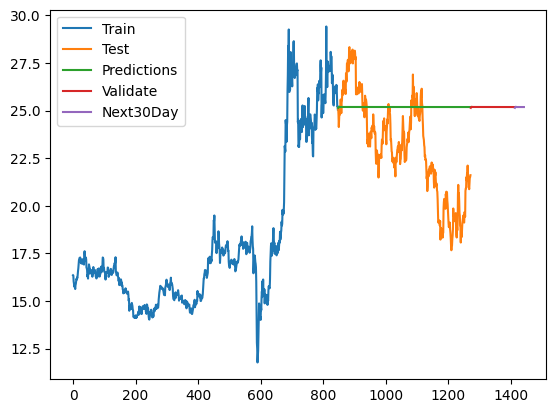

In [22]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

# SPLITTING DATA(5-3-2)

In [23]:
# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [24]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=502.246, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1046.248, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=725.448, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=503.985, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=497.136, Time=0.28 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=499.940, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=498.328, Time=0.14 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=480.862, Time=0.61 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=inf, Time=0.84 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=inf, Time=1.51 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.96 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 6.396 seconds


ARIMA(order=(0, 2, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [25]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [26]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[28.92603602 29.01422436 29.11325806 29.21229177 29.31132547 29.41035918
 29.50939289 29.60842659 29.7074603  29.80649401 29.90552771 30.00456142
 30.10359513 30.20262883 30.30166254 30.40069624 30.49972995 30.59876366
 30.69779736 30.79683107 30.89586478 30.99489848 31.09393219 31.1929659
 31.2919996  31.39103331 31.49006701 31.58910072 31.68813443 31.78716813]


In [27]:
# Calculate accuracy for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  28.092837870858045
Testing MAE:  24.973333335872848
Testing MAPE:  102.50601715765089
Validation RMSE:  22.182932490306527
Validation MAE:  21.10875542385376
Validation MAPE:  96.44259142159488


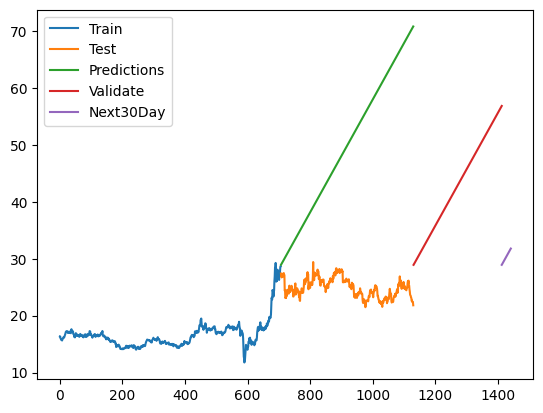

In [28]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

# EVALUATING MODEL

---

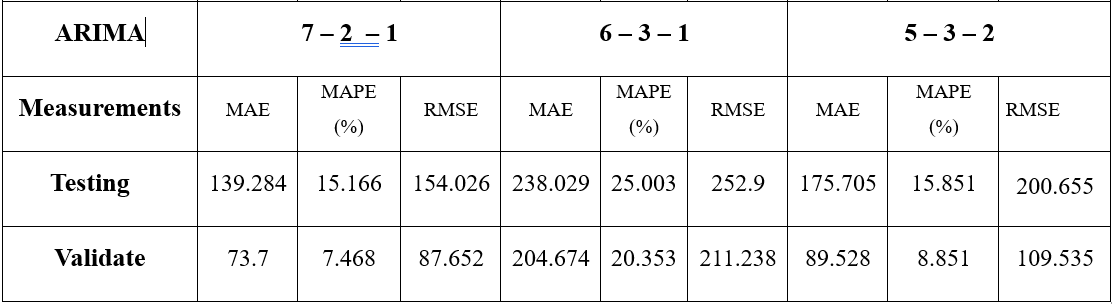